# Trabajo Final - Series de Tiempo 2
## Analisis Comparativo de Modelos para Bitcoin Forecasting

**Universidad de Buenos Aires - Facultad de Ingenieria - LSE**  
**Docente:** Camilo Argoty  
**Especializacion:** Inteligencia Artificial  
**Curso:** Analisis de Series de Tiempo

---

### Version 2: Arquitecturas Mejoradas
Este notebook utiliza las arquitecturas mejoradas de los modelos de las carpetas:
- `lstm/bitcoin_lstm.py`
- `transformer/bitcoin_transformer.py`
- `informer/bitcoin_informer.py`

In [10]:
# Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import math

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Seeds
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA: {torch.cuda.is_available()}")

# Config
CONFIG = {
    'ticker': 'BTC-USD',
    'start_date': '2020-01-01',
    'end_date': '2024-11-01',
    'train_ratio': 0.80,
    'forecast_horizons': [7, 14, 30],
    'output_dir': 'final_st2_results_v2',
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)
print(f"\nResultados en: {CONFIG['output_dir']}/")

PyTorch: 2.9.0+cpu
Device: cpu
CUDA: False

Resultados en: final_st2_results_v2/


## 1. Carga de Datos

In [11]:
print("Descargando Bitcoin...")
data = yf.download(CONFIG['ticker'], 
                   start=CONFIG['start_date'], 
                   end=CONFIG['end_date'],
                   progress=False)

print(f"\nDatos: {len(data)} observaciones")
print(f"Periodo: {data.index[0].date()} a {data.index[-1].date()}")
print(f"\nPrimeras filas:")
data.head()

Descargando Bitcoin...

Datos: 1766 observaciones
Periodo: 2020-01-01 a 2024-10-31

Primeras filas:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [12]:
# Estadisticas
print("ESTADISTICAS")
print(f"Precio inicial: ${float(data['Close'].iloc[0]):,.2f}")
print(f"Precio final:   ${float(data['Close'].iloc[-1]):,.2f}")
print(f"Precio minimo:  ${float(data['Close'].min()):,.2f}")
print(f"Precio maximo:  ${float(data['Close'].max()):,.2f}")
print(f"Precio promedio: ${float(data['Close'].mean()):,.2f}")

returns_total = ((float(data['Close'].iloc[-1]) / float(data['Close'].iloc[0])) - 1) * 100
print(f"\nRetorno total: {returns_total:+.2f}%")

daily_returns = data['Close'].pct_change().dropna()
volatility = float(daily_returns.std() * np.sqrt(252) * 100)
print(f"Volatilidad anualizada: {volatility:.2f}%")

ESTADISTICAS
Precio inicial: $7,200.17
Precio final:   $70,215.19
Precio minimo:  $4,970.79
Precio maximo:  $73,083.50
Precio promedio: $34,376.83

Retorno total: +875.19%
Volatilidad anualizada: 53.50%


In [13]:
# Train/Test split
split_idx = int(len(data) * CONFIG['train_ratio'])
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Train: {len(train_data)} obs ({CONFIG['train_ratio']*100:.0f}%)")
print(f"Test:  {len(test_data)} obs ({(1-CONFIG['train_ratio'])*100:.0f}%)")

Train: 1412 obs (80%)
Test:  354 obs (20%)


## 2. Visualizacion EDA

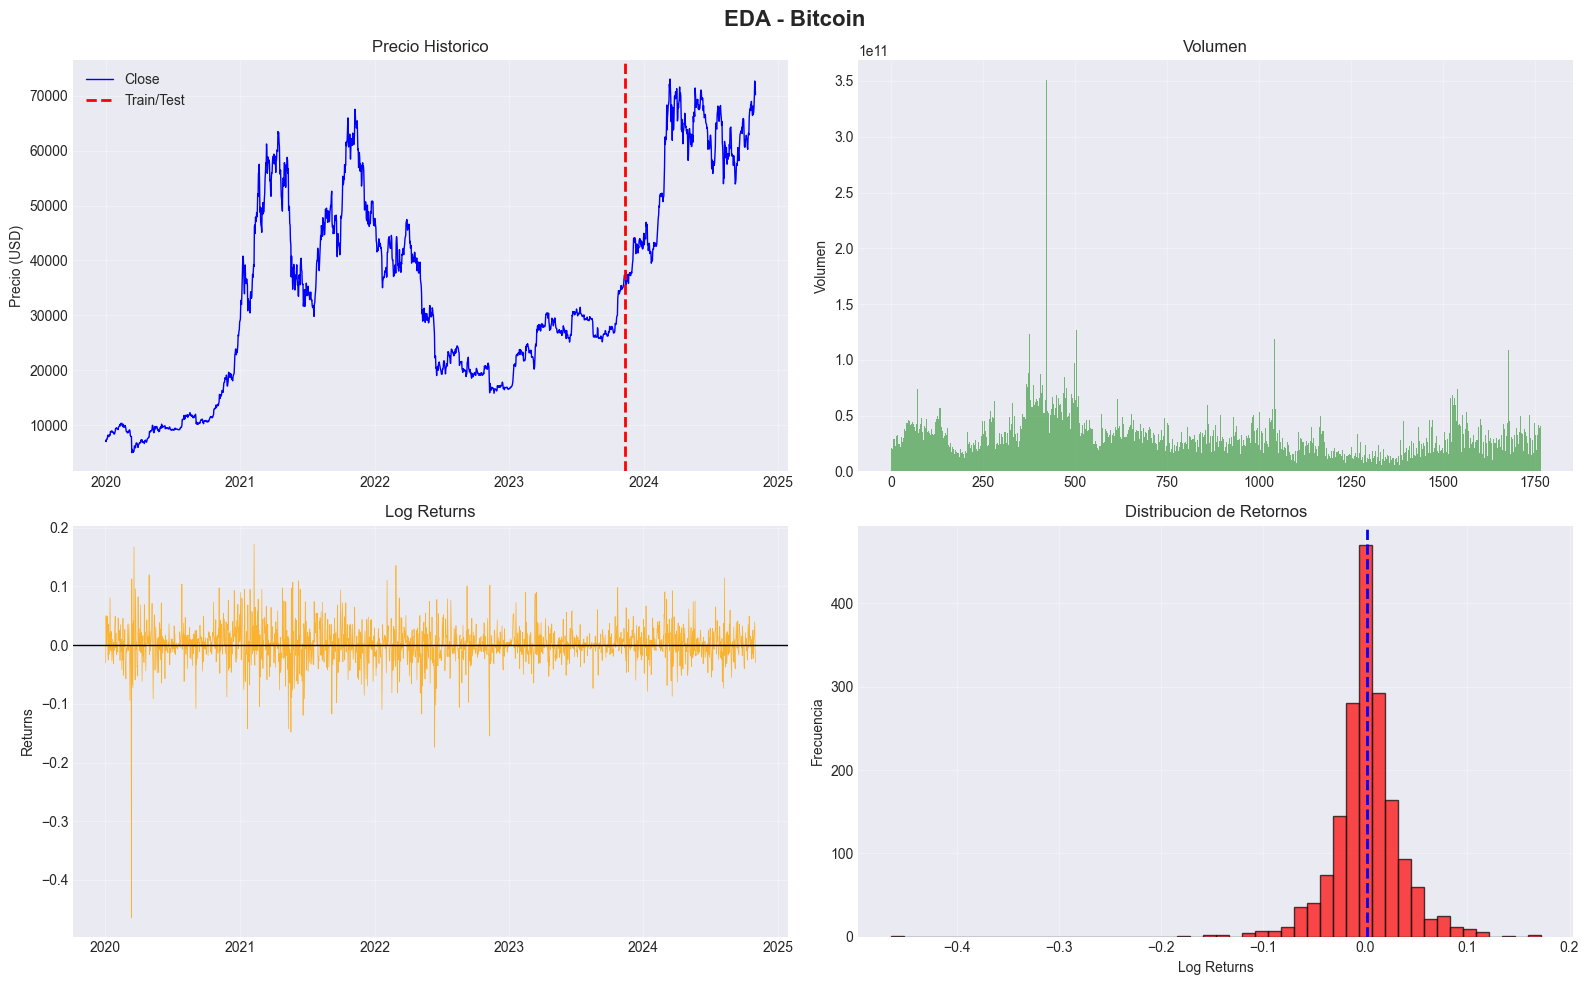

EDA guardado.


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('EDA - Bitcoin', fontsize=16, fontweight='bold')

# Precio
ax = axes[0, 0]
ax.plot(data.index, data['Close'].values, linewidth=1, color='blue', label='Close')
ax.axvline(train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train/Test')
ax.set_title('Precio Historico')
ax.set_ylabel('Precio (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# Volumen
ax = axes[0, 1]
volume_values = data['Volume'].values.flatten()
ax.bar(range(len(volume_values)), volume_values, color='green', alpha=0.5, width=1)
ax.set_title('Volumen')
ax.set_ylabel('Volumen')
ax.grid(True, alpha=0.3)

# Retornos
ax = axes[1, 0]
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
ax.plot(returns.index, returns.values, linewidth=0.5, color='orange', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_title('Log Returns')
ax.set_ylabel('Returns')
ax.grid(True, alpha=0.3)

# Distribucion
ax = axes[1, 1]
ax.hist(returns.values.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
ax.axvline(float(returns.mean()), color='blue', linestyle='--', linewidth=2)
ax.set_title('Distribucion de Retornos')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/01_EDA.png", dpi=300, bbox_inches='tight')
plt.show()
print("EDA guardado.")

## 3. Tests de Estacionariedad

In [15]:
print("TESTS DE ESTACIONARIEDAD")
print("="*60)

# Precios
print("\n[1] PRECIOS (nivel 0)")
adf_result = adfuller(data['Close'].dropna())
kpss_result = kpss(data['Close'].dropna(), regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'NO ESTACIONARIO' if adf_result[1] > 0.05 else 'ESTACIONARIO'}")

# Primera diferencia
print("\n[2] PRIMERA DIFERENCIA")
diff1 = data['Close'].diff().dropna()
adf_result = adfuller(diff1)
kpss_result = kpss(diff1, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

# Log returns
print("\n[3] LOG RETURNS")
log_ret = np.log(data['Close'] / data['Close'].shift(1)).dropna()
adf_result = adfuller(log_ret)
kpss_result = kpss(log_ret, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

TESTS DE ESTACIONARIEDAD

[1] PRECIOS (nivel 0)
ADF: statistic=-1.0647, p-value=0.7289
KPSS: statistic=0.6489, p-value=0.0100
Conclusion: NO ESTACIONARIO

[2] PRIMERA DIFERENCIA
ADF: statistic=-44.0902, p-value=0.0000
KPSS: statistic=0.1060, p-value=0.1000
Conclusion: ESTACIONARIO

[3] LOG RETURNS
ADF: statistic=-13.7820, p-value=0.0000
KPSS: statistic=0.1445, p-value=0.0527
Conclusion: ESTACIONARIO


## 4. Modelo ARIMA

In [16]:
print("ARIMA - Auto seleccion")
best_aic = np.inf
best_order = None
best_model = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data['Close'], order=(p,d,q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p,d,q)
                    best_model = fitted
            except:
                continue

print(f"Mejor orden: {best_order}")
print(f"AIC: {best_aic:.2f}")

arima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = best_model.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    arima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"\nHorizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nARIMA completado.")

ARIMA - Auto seleccion
Mejor orden: (2, 1, 2)
AIC: 23897.66

Horizonte 7d: RMSE=839.75, MAE=727.62, R2=-0.3839

Horizonte 14d: RMSE=744.07, MAE=638.19, R2=-0.0146

Horizonte 30d: RMSE=3446.22, MAE=2392.03, R2=-0.5375

ARIMA completado.


## 5. Modelo SARIMA

In [17]:
print("SARIMA")
sarima_model = SARIMAX(train_data['Close'], 
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fitted = sarima_model.fit(disp=False)
print(f"AIC: {sarima_fitted.aic:.2f}")

sarima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = sarima_fitted.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    sarima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"Horizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nSARIMA completado.")

SARIMA
AIC: 23679.88
Horizonte 7d: RMSE=818.40, MAE=713.79, R2=-0.3144
Horizonte 14d: RMSE=721.32, MAE=577.28, R2=0.0465
Horizonte 30d: RMSE=3181.76, MAE=2159.79, R2=-0.3105

SARIMA completado.


## 6. Feature Engineering (Igual que lstm/bitcoin_lstm.py)

In [18]:
def create_features(df, verbose=True):
    """Feature engineering completo - igual que lstm/bitcoin_lstm.py"""
    if verbose:
        print("FEATURE ENGINEERING")
        print("="*60)
    
    df = df.copy()
    original_cols = len(df.columns)
    
    # Flatten columns if MultiIndex (from yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # 1. Price-based features
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Price_Change'] = (df['Close'] - df['Open']) / df['Open']
    
    # Upper and Lower shadows - fix for new pandas
    open_close_max = df[['Open', 'Close']].max(axis=1)
    open_close_min = df[['Open', 'Close']].min(axis=1)
    df['Upper_Shadow'] = (df['High'] - open_close_max) / df['Close']
    df['Lower_Shadow'] = (open_close_min - df['Low']) / df['Close']
    
    # 2. Moving averages
    for window in [5, 7, 14, 21, 30, 60]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'MA_{window}_ratio'] = df['Close'] / df[f'MA_{window}']
        
    # 3. Exponential moving averages
    for span in [12, 26]:
        df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
        
    # 4. Volatility indicators
    for window in [5, 10, 20, 30]:
        df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
        df[f'ATR_{window}'] = (df['High'] - df['Low']).rolling(window=window).mean()
    
    # 5. Momentum indicators
    for period in [5, 10, 14, 21]:
        df[f'ROC_{period}'] = ((df['Close'] - df['Close'].shift(period)) / 
                               df['Close'].shift(period)) * 100
        df[f'Momentum_{period}'] = df['Close'] - df['Close'].shift(period)
    
    # 6. RSI
    for period in [14, 21]:
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'RSI_{period}'] = 100 - (100 / (1 + rs))
    
    # 7. MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # 8. Bollinger Bands
    for window in [20]:
        df[f'BB_Middle_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'BB_Std_{window}'] = df['Close'].rolling(window=window).std()
        df[f'BB_Upper_{window}'] = df[f'BB_Middle_{window}'] + 2 * df[f'BB_Std_{window}']
        df[f'BB_Lower_{window}'] = df[f'BB_Middle_{window}'] - 2 * df[f'BB_Std_{window}']
        df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']
        df[f'BB_Position_{window}'] = (df['Close'] - df[f'BB_Lower_{window}']) / (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}'])
    
    # 9. Volume indicators
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA_20']
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # 10. Lagged features
    for lag in [1, 2, 3, 5, 7]:
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
    
    # 11. Time-based features
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['DayOfMonth'] = df.index.day
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.values
    
    # Cyclical encoding
    df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    
    # Drop NaN values
    df = df.dropna()
    
    new_cols = len(df.columns)
    
    if verbose:
        print(f"Features creados: {new_cols - original_cols}")
        print(f"Total features: {new_cols}")
        print(f"Samples validos: {len(df)}")
    
    return df

# Aplicar
df_features = create_features(data.copy(), verbose=True)

# Seleccionar features (excluir time features categoricas)
exclude_cols = ['DayOfWeek', 'Month', 'Quarter', 'DayOfMonth', 'DayOfYear', 'WeekOfYear']
feature_cols = [col for col in df_features.columns if col not in exclude_cols]
df_model = df_features[feature_cols].copy()

print(f"\nFeatures para modelo: {len(feature_cols)}")

FEATURE ENGINEERING
Features creados: 72
Total features: 77
Samples validos: 1707

Features para modelo: 71


## 7. Arquitecturas de Deep Learning (Copiadas de los scripts mejorados)

In [19]:
# ============================================================================
# LSTM MODEL (de lstm/bitcoin_lstm.py)
# ============================================================================

class LSTMModel(nn.Module):
    """LSTM model para time series forecasting - Arquitectura de lstm/bitcoin_lstm.py"""
    
    def __init__(self, input_dim, hidden_dim, num_layers, pred_len, dropout=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.pred_len = pred_len
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Fully connected output layers
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim // 2, pred_len)
        
    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)
        h_0 = torch.zeros(self.num_layers, src.size(0), self.hidden_dim).to(src.device)
        c_0 = torch.zeros(self.num_layers, src.size(0), self.hidden_dim).to(src.device)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(src, (h_0, c_0))
        
        # Use last timestep
        out = lstm_out[:, -1, :]
        
        # Layer norm
        out = self.layer_norm(out)
        
        # Output layers
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

print("LSTMModel definido (arquitectura de lstm/bitcoin_lstm.py)")

LSTMModel definido (arquitectura de lstm/bitcoin_lstm.py)


In [20]:
# ============================================================================
# TRANSFORMER MODEL (de transformer/bitcoin_transformer.py)
# ============================================================================

class PositionalEncoding(nn.Module):
    """Positional encoding para Transformer"""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class TimeSeriesTransformer(nn.Module):
    """Transformer model - Arquitectura de transformer/bitcoin_transformer.py"""
    
    def __init__(self, input_dim, d_model, nhead, num_layers, 
                 dim_feedforward, pred_len, dropout=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.fc1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(dim_feedforward, dim_feedforward // 2)
        self.fc3 = nn.Linear(dim_feedforward // 2, pred_len)
        
        self.relu = nn.ReLU()
        
    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)
        
        # Project to d_model dimensions
        src = self.input_projection(src)
        
        # Add positional encoding
        src = self.pos_encoder(src)
        
        # Transformer encoder
        output = self.transformer_encoder(src)
        
        # Layer normalization
        output = self.layer_norm(output)
        
        # Use last time step
        output = output[:, -1, :]
        
        # Output layers
        output = self.relu(self.fc1(output))
        output = self.dropout(output)
        output = self.relu(self.fc2(output))
        output = self.dropout(output)
        output = self.fc3(output)
        
        return output

print("TimeSeriesTransformer definido (arquitectura de transformer/bitcoin_transformer.py)")

TimeSeriesTransformer definido (arquitectura de transformer/bitcoin_transformer.py)


In [21]:
# ============================================================================
# INFORMER MODEL (de informer/bitcoin_informer.py)
# ============================================================================

class ProbAttention(nn.Module):
    """ProbSparse Self-Attention - Reduce complejidad de O(L^2) a O(L log L)"""
    
    def __init__(self, mask_flag=True, factor=5, scale=None, 
                 attention_dropout=0.1, output_attention=False):
        super().__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask=None):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape
        
        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)
        
        # Standard attention for simplicity
        scale = self.scale or 1. / math.sqrt(D)
        scores = torch.matmul(queries, keys.transpose(-2, -1))
        attn = self.dropout(torch.softmax(scale * scores, dim=-1))
        context = torch.matmul(attn, values)
        
        return context.transpose(2, 1).contiguous()


class AttentionLayer(nn.Module):
    """Capa de atencion con proyecciones lineales"""
    
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super().__init__()
        
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        
    def forward(self, queries, keys, values, attn_mask=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        
        out = self.inner_attention(queries, keys, values, attn_mask)
        out = out.view(B, L, -1)
        
        return self.out_projection(out)


class EncoderLayer(nn.Module):
    """Capa del encoder de Informer"""
    
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu
        
    def forward(self, x, attn_mask=None):
        new_x = self.attention(x, x, x, attn_mask=attn_mask)
        x = x + self.dropout(new_x)
        
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        return self.norm2(x + y)


class InformerEncoder(nn.Module):
    """Encoder del Informer"""
    
    def __init__(self, attn_layers, norm_layer=None):
        super().__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer
        
    def forward(self, x, attn_mask=None):
        for attn_layer in self.attn_layers:
            x = attn_layer(x, attn_mask=attn_mask)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x


class InformerPositionalEncoding(nn.Module):
    """Positional encoding para Informer"""
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * 
                    -(math.log(10000.0) / d_model)).exp()
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


class Informer(nn.Module):
    """Informer: Efficient Long Sequence Forecasting - Arquitectura de informer/bitcoin_informer.py"""
    
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, pred_len,
                 factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2,
                 d_ff=512, dropout=0.0, activation='gelu'):
        super().__init__()
        self.pred_len = pred_len
        self.c_out = c_out
        
        # Embedding
        self.enc_embedding = nn.Linear(enc_in, d_model)
        self.pos_embedding = InformerPositionalEncoding(d_model, dropout=dropout)
        
        # Encoder
        self.encoder = InformerEncoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, factor, attention_dropout=dropout, output_attention=False),
                        d_model, n_heads
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for _ in range(e_layers)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )
        
        # Projection
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x):
        # x: [Batch, Seq, Features]
        
        # Embedding
        enc_out = self.enc_embedding(x)
        enc_out = self.pos_embedding(enc_out)
        
        # Encoder
        enc_out = self.encoder(enc_out, attn_mask=None)
        
        # Projection (use last timestep)
        output = self.projection(enc_out[:, -1, :])
        
        return output

print("Informer definido (arquitectura de informer/bitcoin_informer.py)")

Informer definido (arquitectura de informer/bitcoin_informer.py)


## 8. Preparacion de Datos para Deep Learning

In [22]:
# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.pred_len, 0]  # Close price
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Configuracion DL
DL_CONFIG = {
    'seq_len': 60,
    'pred_len': 7,
    'batch_size': 32,
    'epochs': 100,
    'learning_rate': 0.001,
    'patience': 15,
    'train_ratio': 0.7,
    'val_ratio': 0.15,
}

# Normalizar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model.values)

# Split data
n = len(scaled_data)
train_size = int(n * DL_CONFIG['train_ratio'])
val_size = int(n * DL_CONFIG['val_ratio'])

train_data_dl = scaled_data[:train_size]
val_data_dl = scaled_data[train_size:train_size + val_size]
test_data_dl = scaled_data[train_size + val_size:]

print(f"Train: {len(train_data_dl)} ({DL_CONFIG['train_ratio']*100:.0f}%)")
print(f"Val: {len(val_data_dl)} ({DL_CONFIG['val_ratio']*100:.0f}%)")
print(f"Test: {len(test_data_dl)} ({(1-DL_CONFIG['train_ratio']-DL_CONFIG['val_ratio'])*100:.0f}%)")

# Crear datasets
train_dataset = TimeSeriesDataset(train_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])
val_dataset = TimeSeriesDataset(val_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])
test_dataset = TimeSeriesDataset(test_data_dl, DL_CONFIG['seq_len'], DL_CONFIG['pred_len'])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=DL_CONFIG['batch_size'], shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train: 1194 (70%)
Val: 256 (15%)
Test: 257 (15%)

Train batches: 36
Val batches: 6
Test batches: 6


## 9. Funciones de Entrenamiento y Evaluacion

In [23]:
def train_model(model, train_loader, val_loader, epochs, lr, patience, model_name):
    """Entrena un modelo con early stopping"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None
    train_losses, val_losses = [], []
    
    print(f"\n{'='*60}")
    print(f"Entrenando {model_name}")
    print(f"{'='*60}")
    print(f"Parametros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Device: {device}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output.squeeze(), batch_y.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                output = model(batch_x)
                loss = criterion(output.squeeze(), batch_y.squeeze())
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train: {train_loss:.6f} Val: {val_loss:.6f}")
        
        if patience_counter >= patience:
            print(f"Early stopping en epoca {epoch+1}")
            break
    
    # Restaurar mejor modelo
    model.load_state_dict(best_state)
    model = model.to(device)
    print(f"Mejor val loss: {best_val_loss:.6f}")
    
    return model, train_losses, val_losses


def evaluate_model(model, test_loader, scaler, close_idx=0):
    """Evalua modelo y calcula metricas"""
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            output = model(batch_x)
            predictions.append(output.cpu().numpy())
            actuals.append(batch_y.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Inverse transform
    n_features = scaler.n_features_in_
    
    if len(predictions.shape) == 1:
        predictions = predictions.reshape(-1, 1)
        actuals = actuals.reshape(-1, 1)
    
    pred_rescaled = np.zeros_like(predictions)
    actual_rescaled = np.zeros_like(actuals)
    
    for i in range(predictions.shape[1]):
        pred_full = np.zeros((predictions.shape[0], n_features))
        actual_full = np.zeros((actuals.shape[0], n_features))
        
        pred_full[:, close_idx] = predictions[:, i]
        actual_full[:, close_idx] = actuals[:, i]
        
        pred_rescaled[:, i] = scaler.inverse_transform(pred_full)[:, close_idx]
        actual_rescaled[:, i] = scaler.inverse_transform(actual_full)[:, close_idx]
    
    # Calcular metricas
    metrics = {}
    for i in range(pred_rescaled.shape[1]):
        pred = pred_rescaled[:, i]
        actual = actual_rescaled[:, i]
        
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        
        metrics[f'Day_{i+1}'] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    
    return pred_rescaled, actual_rescaled, metrics

print("Funciones de entrenamiento y evaluacion definidas.")

Funciones de entrenamiento y evaluacion definidas.


## 10. Entrenar LSTM

In [24]:
print("LSTM (Arquitectura de lstm/bitcoin_lstm.py)")

# Crear modelo LSTM
lstm_model = LSTMModel(
    input_dim=len(feature_cols),
    hidden_dim=128,
    num_layers=3,
    pred_len=DL_CONFIG['pred_len'],
    dropout=0.1
)

# Entrenar
lstm_model, lstm_train_losses, lstm_val_losses = train_model(
    lstm_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=DL_CONFIG['learning_rate'],
    patience=DL_CONFIG['patience'],
    model_name="LSTM"
)

# Evaluar
close_idx = feature_cols.index('Close')
lstm_pred, lstm_actual, lstm_metrics = evaluate_model(lstm_model, test_loader, scaler, close_idx)

print("\nLSTM Metricas:")
for day, m in lstm_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(lstm_model.state_dict(), f"{CONFIG['output_dir']}/lstm_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/lstm_model.pth")

LSTM (Arquitectura de lstm/bitcoin_lstm.py)

Entrenando LSTM
Parametros: 376,071
Device: cpu
Epoch [10/100] Train: 0.021383 Val: 0.027857
Early stopping en epoca 18
Mejor val loss: 0.015023

LSTM Metricas:
  Day_1: RMSE=8180.25, R2=-3.1789
  Day_2: RMSE=9403.36, R2=-4.4956
  Day_3: RMSE=10398.29, R2=-5.6720
  Day_4: RMSE=10573.72, R2=-5.8073
  Day_5: RMSE=11213.92, R2=-6.4499
  Day_6: RMSE=11226.77, R2=-6.3094
  Day_7: RMSE=12568.76, R2=-8.0564

Modelo guardado: final_st2_results_v2/lstm_model.pth


## 11. Entrenar Transformer

In [25]:
print("TRANSFORMER (Arquitectura de transformer/bitcoin_transformer.py)")

# Crear modelo Transformer
transformer_model = TimeSeriesTransformer(
    input_dim=len(feature_cols),
    d_model=128,
    nhead=8,
    num_layers=3,
    dim_feedforward=512,
    pred_len=DL_CONFIG['pred_len'],
    dropout=0.1
)

# Entrenar
transformer_model, transformer_train_losses, transformer_val_losses = train_model(
    transformer_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=DL_CONFIG['learning_rate'],
    patience=DL_CONFIG['patience'],
    model_name="Transformer"
)

# Evaluar
transformer_pred, transformer_actual, transformer_metrics = evaluate_model(
    transformer_model, test_loader, scaler, close_idx
)

print("\nTransformer Metricas:")
for day, m in transformer_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(transformer_model.state_dict(), f"{CONFIG['output_dir']}/transformer_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/transformer_model.pth")

TRANSFORMER (Arquitectura de transformer/bitcoin_transformer.py)

Entrenando Transformer
Parametros: 803,463
Device: cpu
Epoch [10/100] Train: 0.016305 Val: 0.056049
Epoch [20/100] Train: 0.007983 Val: 0.044379
Early stopping en epoca 20
Mejor val loss: 0.013709

Transformer Metricas:
  Day_1: RMSE=6999.44, R2=-2.0595
  Day_2: RMSE=7843.89, R2=-2.8239
  Day_3: RMSE=8338.64, R2=-3.2907
  Day_4: RMSE=9216.83, R2=-4.1723
  Day_5: RMSE=8656.98, R2=-3.4398
  Day_6: RMSE=9429.83, R2=-4.1568
  Day_7: RMSE=10590.53, R2=-5.4299

Modelo guardado: final_st2_results_v2/transformer_model.pth


## 12. Entrenar Informer

In [26]:
print("INFORMER (Arquitectura de informer/bitcoin_informer.py)")

# Crear modelo Informer
informer_model = Informer(
    enc_in=len(feature_cols),
    dec_in=len(feature_cols),
    c_out=DL_CONFIG['pred_len'],
    seq_len=DL_CONFIG['seq_len'],
    label_len=DL_CONFIG['seq_len']//2,
    pred_len=DL_CONFIG['pred_len'],
    factor=5,
    d_model=512,
    n_heads=8,
    e_layers=2,
    d_layers=1,
    d_ff=2048,
    dropout=0.05
)

# Entrenar (LR mas bajo para Informer)
informer_model, informer_train_losses, informer_val_losses = train_model(
    informer_model, train_loader, val_loader,
    epochs=DL_CONFIG['epochs'],
    lr=0.0001,
    patience=DL_CONFIG['patience'],
    model_name="Informer"
)

# Evaluar
informer_pred, informer_actual, informer_metrics = evaluate_model(
    informer_model, test_loader, scaler, close_idx
)

print("\nInformer Metricas:")
for day, m in informer_metrics.items():
    print(f"  {day}: RMSE={m['RMSE']:.2f}, R2={m['R2']:.4f}")

# Guardar modelo
torch.save(informer_model.state_dict(), f"{CONFIG['output_dir']}/informer_model.pth")
print(f"\nModelo guardado: {CONFIG['output_dir']}/informer_model.pth")

INFORMER (Arquitectura de informer/bitcoin_informer.py)

Entrenando Informer
Parametros: 6,346,247
Device: cpu
Epoch [10/100] Train: 0.012285 Val: 0.025926
Early stopping en epoca 18
Mejor val loss: 0.014091

Informer Metricas:
  Day_1: RMSE=6246.61, R2=-1.4368
  Day_2: RMSE=4150.65, R2=-0.0707
  Day_3: RMSE=5379.28, R2=-0.7856
  Day_4: RMSE=4670.34, R2=-0.3281
  Day_5: RMSE=6176.31, R2=-1.2599
  Day_6: RMSE=6594.86, R2=-1.5222
  Day_7: RMSE=7425.81, R2=-2.1612

Modelo guardado: final_st2_results_v2/informer_model.pth


## 13. Generar Forecasts para Horizontes Especificos

In [27]:
def get_dl_forecasts_for_horizon(model, scaler, close_idx, train_scaled, horizon, seq_len=60):
    """Genera forecasts para un horizonte especifico"""
    model.eval()
    
    last_sequence = train_scaled[-seq_len:].reshape(1, seq_len, -1)
    predictions = []
    current_seq = torch.FloatTensor(last_sequence).to(device)
    
    n_features = train_scaled.shape[1]
    
    with torch.no_grad():
        for _ in range(horizon):
            pred = model(current_seq)
            if len(pred.shape) > 1 and pred.shape[1] > 1:
                next_val_scaled = pred[0, 0].item()
            else:
                next_val_scaled = pred[0].item() if len(pred.shape) > 1 else pred.item()
            
            dummy = np.zeros((1, n_features))
            dummy[0, close_idx] = next_val_scaled
            next_val_actual = scaler.inverse_transform(dummy)[0, close_idx]
            predictions.append(next_val_actual)
            
            new_features = np.zeros((1, 1, n_features))
            new_features[0, 0, close_idx] = next_val_scaled
            new_features_tensor = torch.FloatTensor(new_features).to(device)
            current_seq = torch.cat([current_seq[:, 1:, :], new_features_tensor], dim=1)
    
    return np.array(predictions)

# Generar forecasts
lstm_forecasts = {}
transformer_forecasts = {}
informer_forecasts = {}

for horizon in CONFIG['forecast_horizons']:
    print(f"\nGenerando forecasts para horizonte {horizon} dias...")
    actual = test_data['Close'].iloc[:horizon].values
    
    # LSTM
    forecast = get_dl_forecasts_for_horizon(lstm_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    lstm_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  LSTM: RMSE={rmse:.2f}, R2={r2:.4f}")
    
    # Transformer
    forecast = get_dl_forecasts_for_horizon(transformer_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    transformer_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  Transformer: RMSE={rmse:.2f}, R2={r2:.4f}")
    
    # Informer
    forecast = get_dl_forecasts_for_horizon(informer_model, scaler, close_idx, train_data_dl, horizon)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    informer_forecasts[horizon] = {
        'forecast': forecast, 'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    print(f"  Informer: RMSE={rmse:.2f}, R2={r2:.4f}")

print("\nForecasts generados.")


Generando forecasts para horizonte 7 dias...
  LSTM: RMSE=8319.50, R2=-134.8305
  Transformer: RMSE=9180.80, R2=-164.4107
  Informer: RMSE=8393.67, R2=-137.2633

Generando forecasts para horizonte 14 dias...
  LSTM: RMSE=5958.20, R2=-64.0553
  Transformer: RMSE=8802.22, R2=-140.9832
  Informer: RMSE=8069.53, R2=-118.3298

Generando forecasts para horizonte 30 dias...
  LSTM: RMSE=5554.68, R2=-2.9943
  Transformer: RMSE=9395.85, R2=-10.4285
  Informer: RMSE=9516.66, R2=-10.7243

Forecasts generados.


## 14. Comparacion Final

In [28]:
all_results = {
    'ARIMA': arima_forecasts,
    'SARIMA': sarima_forecasts,
    'LSTM': lstm_forecasts,
    'Transformer': transformer_forecasts,
    'Informer': informer_forecasts
}

for horizon in CONFIG['forecast_horizons']:
    print(f"\n{'='*60}")
    print(f"COMPARACION - HORIZONTE {horizon} DIAS")
    print(f"{'='*60}")
    
    comparison_data = []
    for model_name, forecasts in all_results.items():
        if horizon in forecasts:
            metrics = forecasts[horizon]['metrics']
            comparison_data.append({
                'Modelo': model_name,
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'MAPE': metrics['MAPE']
            })
    
    df_comp = pd.DataFrame(comparison_data).sort_values('RMSE')
    df_comp.to_csv(f"{CONFIG['output_dir']}/comparison_{horizon}d.csv", index=False)
    
    print(df_comp.to_string(index=False))
    print(f"\nMEJOR: {df_comp.iloc[0]['Modelo']} (RMSE={df_comp.iloc[0]['RMSE']:.2f})")


COMPARACION - HORIZONTE 7 DIAS
     Modelo        RMSE         MAE          R2      MAPE
     SARIMA  818.402336  713.792560   -0.314427       NaN
      ARIMA  839.749396  727.624462   -0.383892       NaN
       LSTM 8319.499476 7492.895823 -134.830451 20.406909
   Informer 8393.674849 8236.152933 -137.263335 22.434916
Transformer 9180.798937 9125.646838 -164.410738 24.861936

MEJOR: SARIMA (RMSE=818.40)

COMPARACION - HORIZONTE 14 DIAS
     Modelo        RMSE         MAE          R2      MAPE
     SARIMA  721.320140  577.277393    0.046527       NaN
      ARIMA  744.073085  638.190947   -0.014574       NaN
       LSTM 5958.198486 4343.038931  -64.055263 11.926038
   Informer 8069.527734 7973.188418 -118.329752 21.531913
Transformer 8802.219416 8757.351934 -140.983174 23.653550

MEJOR: SARIMA (RMSE=721.32)

COMPARACION - HORIZONTE 30 DIAS
     Modelo        RMSE         MAE         R2      MAPE
     SARIMA 3181.760748 2159.792943  -0.310549       NaN
      ARIMA 3446.220644 2392.02605

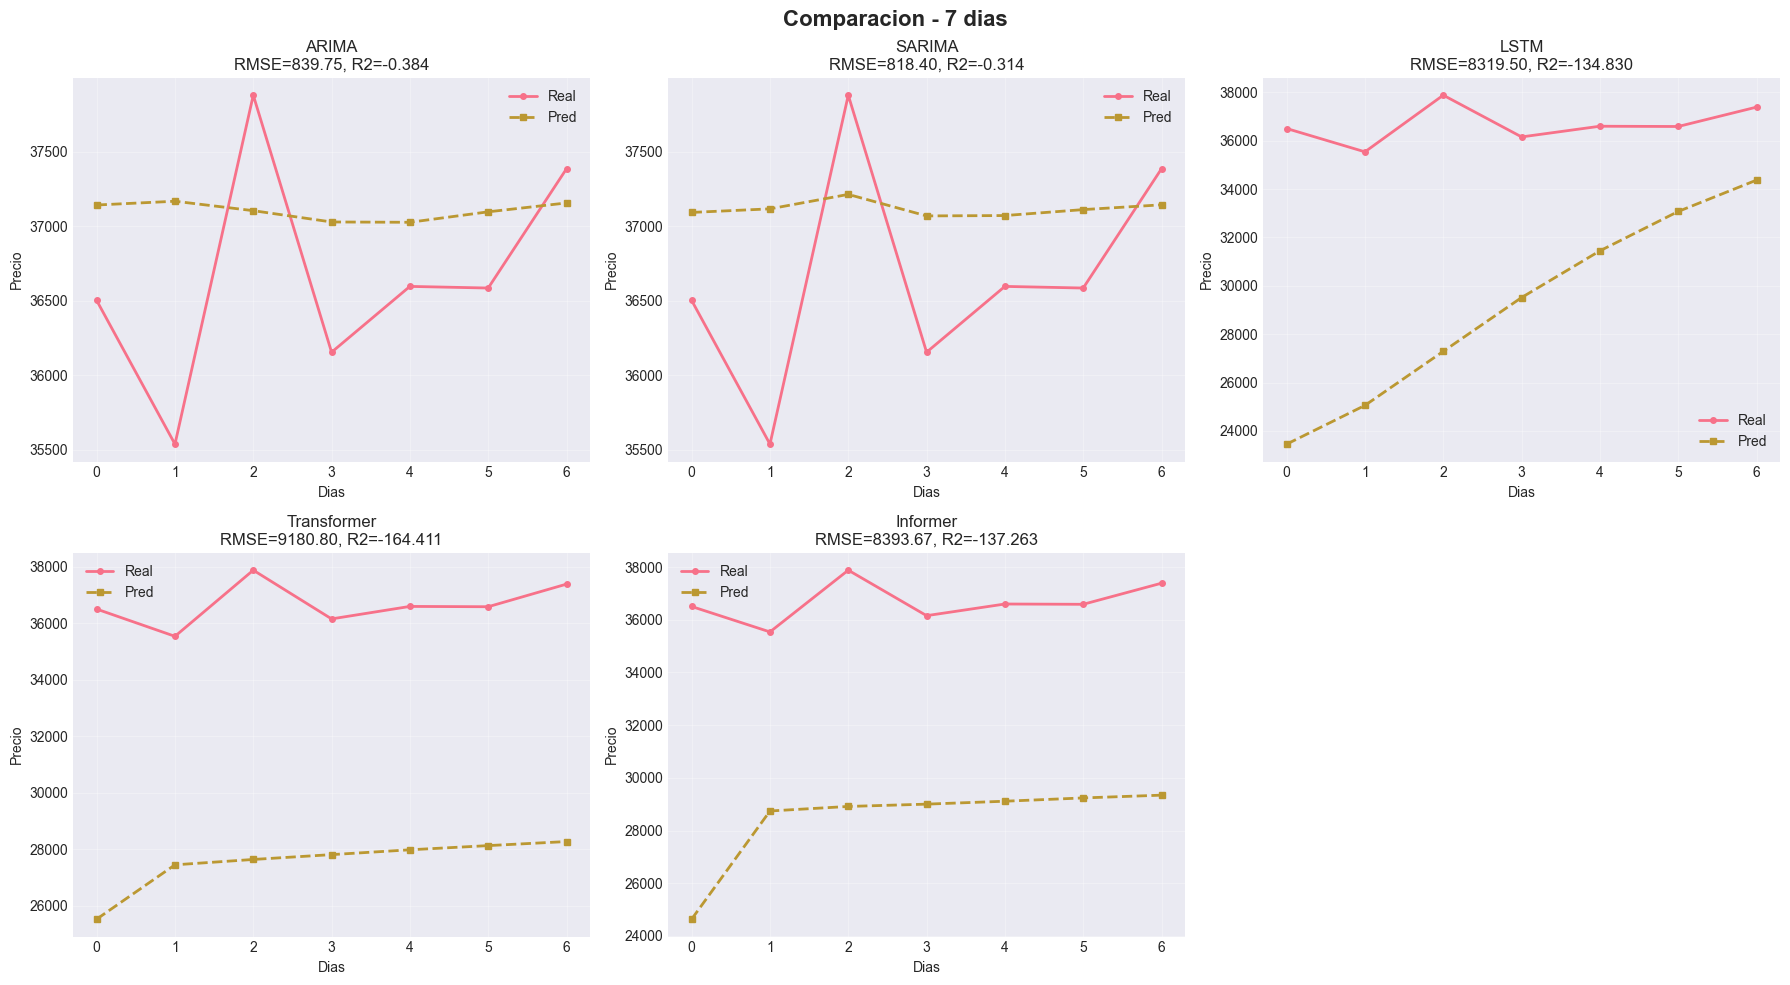

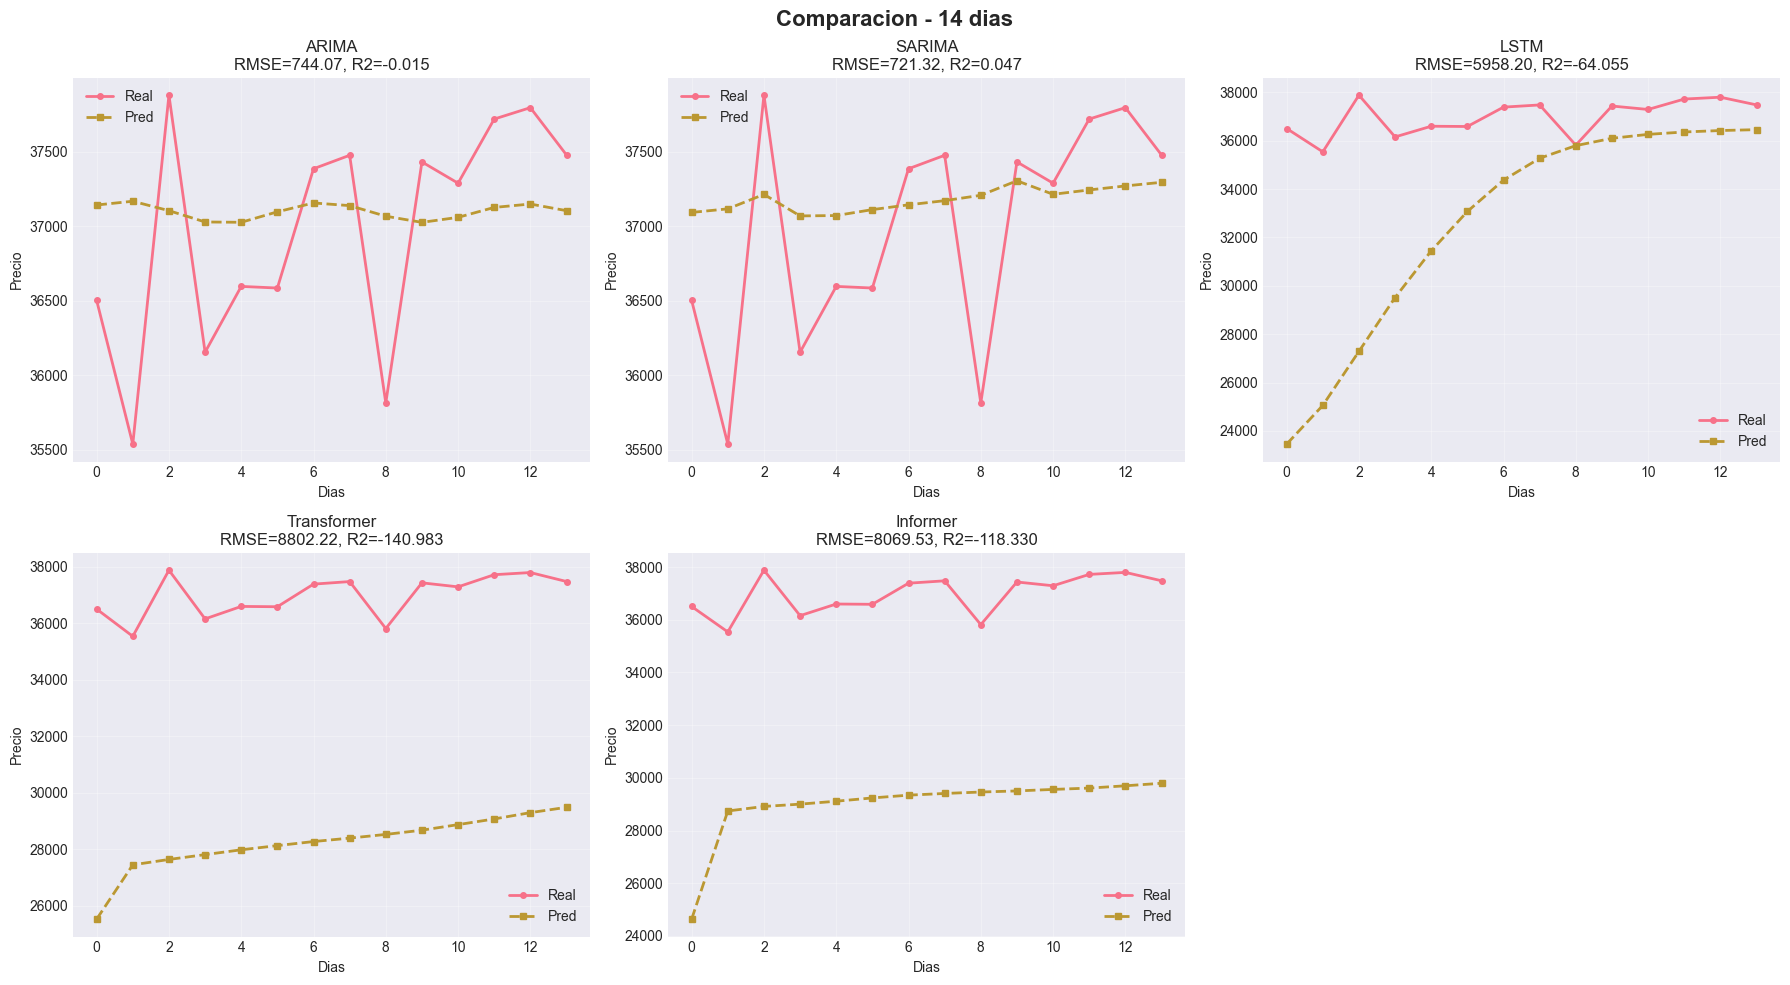

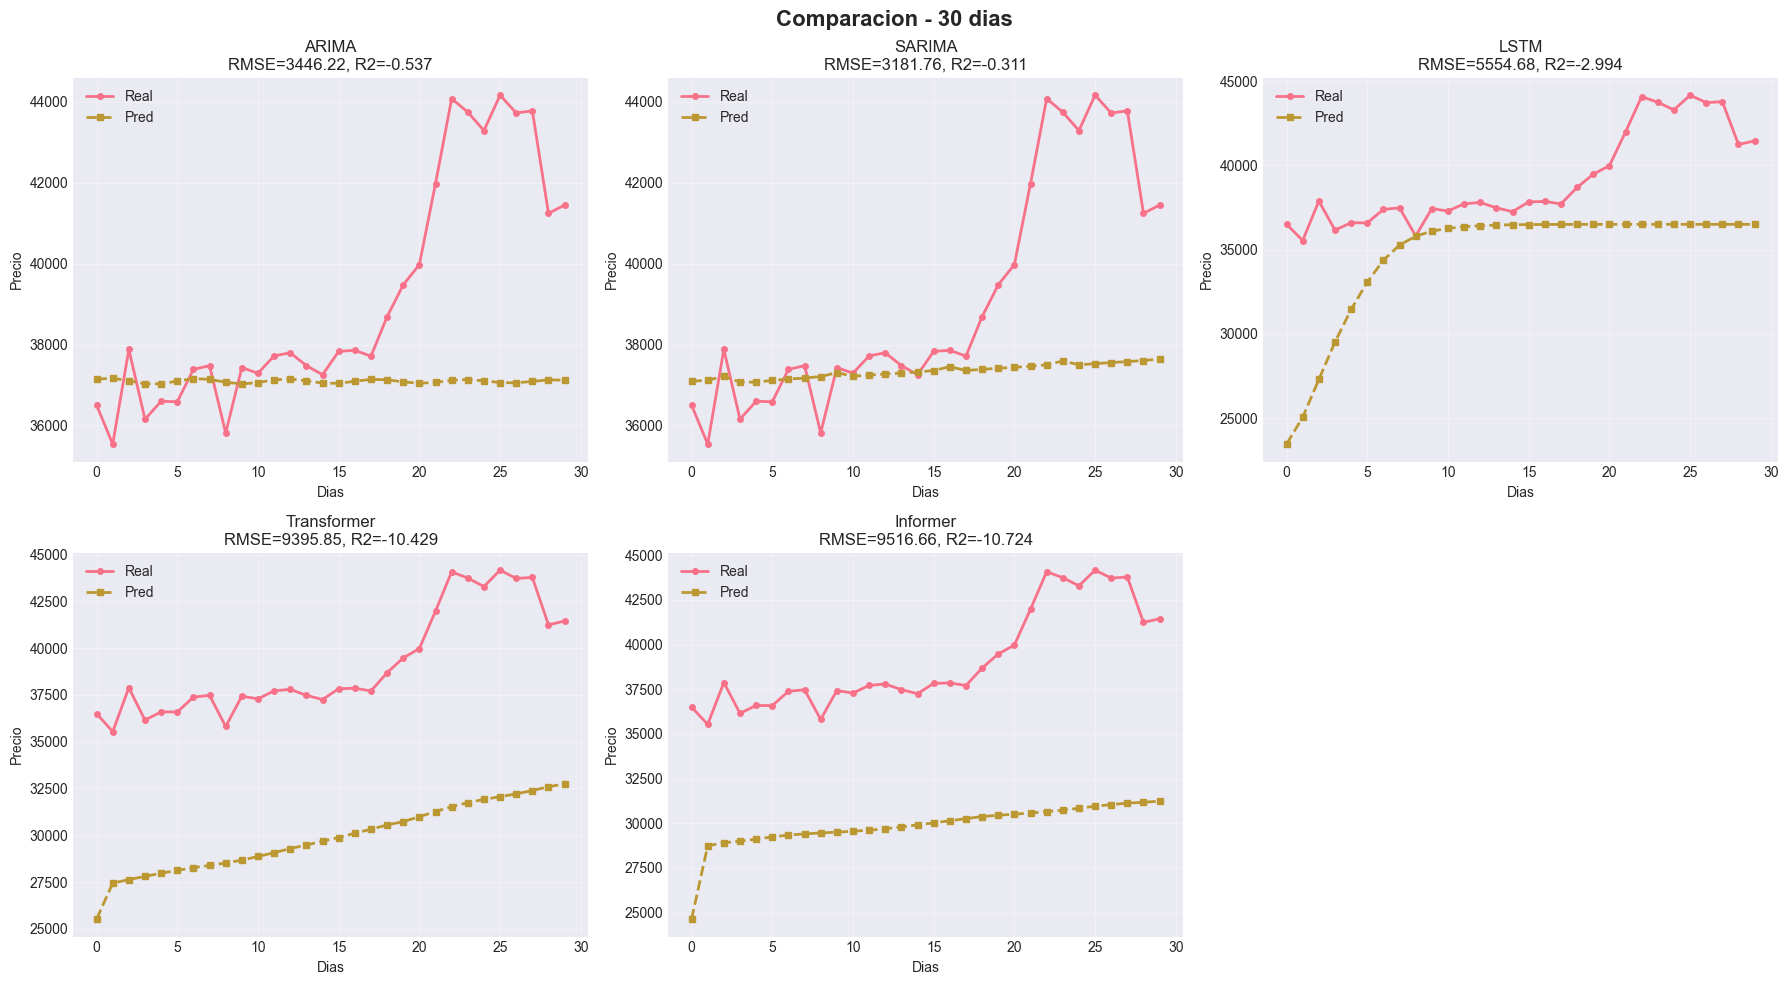


ANALISIS COMPLETO FINALIZADO
Resultados en: final_st2_results_v2/


In [29]:
# Visualizacion
for horizon in CONFIG['forecast_horizons']:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Comparacion - {horizon} dias', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    idx = 0
    for model_name, forecasts in all_results.items():
        if horizon in forecasts and idx < len(axes):
            ax = axes[idx]
            actual = forecasts[horizon]['actual']
            forecast = forecasts[horizon]['forecast']
            metrics = forecasts[horizon]['metrics']
            
            x = np.arange(len(actual))
            ax.plot(x, actual, 'o-', label='Real', linewidth=2, markersize=4)
            ax.plot(x, forecast, 's--', label='Pred', linewidth=2, markersize=4)
            ax.set_title(f"{model_name}\nRMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.3f}")
            ax.set_xlabel('Dias')
            ax.set_ylabel('Precio')
            ax.legend()
            ax.grid(True, alpha=0.3)
            idx += 1
    
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/comparison_{horizon}d.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("ANALISIS COMPLETO FINALIZADO")
print(f"Resultados en: {CONFIG['output_dir']}/")
print("="*60)

## 15. Resumen

In [30]:
print("\n" + "="*60)
print("RESUMEN DE MODELOS")
print("="*60)
print(f"\nDirectorio: {CONFIG['output_dir']}/")
print("\nArchivos generados:")
for f in sorted(os.listdir(CONFIG['output_dir'])):
    print(f"  - {f}")

print("\n" + "="*60)
print("ARQUITECTURAS UTILIZADAS")
print("="*60)
print("\n1. LSTM (lstm/bitcoin_lstm.py)")
print(f"   - Hidden dim: 128")
print(f"   - Num layers: 3")
print(f"   - Dropout: 0.1")
print(f"   - Parametros: {sum(p.numel() for p in lstm_model.parameters()):,}")

print("\n2. Transformer (transformer/bitcoin_transformer.py)")
print(f"   - d_model: 128")
print(f"   - nhead: 8")
print(f"   - num_layers: 3")
print(f"   - dim_feedforward: 512")
print(f"   - Parametros: {sum(p.numel() for p in transformer_model.parameters()):,}")

print("\n3. Informer (informer/bitcoin_informer.py)")
print(f"   - d_model: 512")
print(f"   - n_heads: 8")
print(f"   - e_layers: 2")
print(f"   - d_ff: 2048")
print(f"   - factor: 5 (ProbSparse attention)")
print(f"   - Parametros: {sum(p.numel() for p in informer_model.parameters()):,}")

print("\n" + "="*60)
print("ANALISIS COMPLETADO EXITOSAMENTE")
print("="*60)


RESUMEN DE MODELOS

Directorio: final_st2_results_v2/

Archivos generados:
  - 01_EDA.png
  - comparison_14d.csv
  - comparison_14d.png
  - comparison_30d.csv
  - comparison_30d.png
  - comparison_7d.csv
  - comparison_7d.png
  - informer_model.pth
  - lstm_model.pth
  - transformer_model.pth

ARQUITECTURAS UTILIZADAS

1. LSTM (lstm/bitcoin_lstm.py)
   - Hidden dim: 128
   - Num layers: 3
   - Dropout: 0.1
   - Parametros: 376,071

2. Transformer (transformer/bitcoin_transformer.py)
   - d_model: 128
   - nhead: 8
   - num_layers: 3
   - dim_feedforward: 512
   - Parametros: 803,463

3. Informer (informer/bitcoin_informer.py)
   - d_model: 512
   - n_heads: 8
   - e_layers: 2
   - d_ff: 2048
   - factor: 5 (ProbSparse attention)
   - Parametros: 6,346,247

ANALISIS COMPLETADO EXITOSAMENTE
